# CacheGuardian Benchmarks — Claude Sonnet 4.6

This notebook reproduces the 6 experiments from the CacheGuardian blog post.
Experiments 1-5 make **real API calls** to Anthropic's Claude Sonnet 4.6. Experiment 6 (model recommendations) runs locally with zero API cost.

**Requirements:**
1. An `ANTHROPIC_API_KEY` environment variable
2. `pip install cacheguardian[anthropic] matplotlib seaborn pandas numpy`

**Estimated cost: ~$0.70** for all experiments (~82 API calls).

| Experiment | Description | API Calls | Approx Cost |
|---|---|---|---|
| 1 | Tool ordering breaks cache | 20 | $0.17 |
| 2 | Dynamic system prompts kill cache | 16 | $0.14 |
| 3 | Dry-run pre-flight validation | 1 | $0.006 |
| 4 | 20-turn conversation savings | 40 | $0.36 |
| 5 | Cache break forensics | 5 | $0.03 |
| 6 | Model recommendations | 0 | $0.00 |

Each experiment is self-contained — you can run them individually or all at once.

---

## Setup & Imports

In [1]:
import os, sys, time, random, json, copy
from datetime import datetime, timedelta
from pathlib import Path

import anthropic
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

# If running from cacheguardian-benchmarks/, add parent for imports
sys.path.insert(0, str(Path.cwd().parent))

import cacheguardian
from cacheguardian.config import PricingConfig
from cacheguardian.core.optimizer import SystemPromptTemplate
from cacheguardian.middleware.interceptor import _GUARD_ATTR

# Verify API key
assert os.environ.get("ANTHROPIC_API_KEY"), (
    "Set ANTHROPIC_API_KEY before running:\n"
    "  export ANTHROPIC_API_KEY='sk-ant-...'"
)

print(f"cacheguardian v{cacheguardian.__version__}")
print(f"anthropic SDK v{anthropic.__version__}")

cacheguardian v0.2.0
anthropic SDK v0.83.0


## Configuration

Change `MODEL` and `PRICING` to benchmark a different Claude variant.

In [2]:
# ── Model & Pricing ──
# See https://docs.anthropic.com/en/docs/about-claude/models for current pricing.
MODEL = "claude-sonnet-4-6"
PRICING = PricingConfig(
    base_input=3.00,        # $/M input tokens
    cache_read=0.30,        # $/M cache-read tokens (90% discount)
    cache_write_5m=3.75,    # $/M cache-write tokens (5-min TTL)
    cache_write_1h=6.00,    # $/M cache-write tokens (1-hr TTL)
    output=15.00,           # $/M output tokens
)

# ── Chart Style ──
CG_GREEN      = "#2ecc71"
RAW_RED       = "#e74c3c"
CACHE_BLUE    = "#3498db"
WRITE_ORANGE  = "#f39c12"
UNCACHED_GRAY = "#95a5a6"
SAVINGS_GREEN = "#27ae60"

CHARTS = Path("charts-sonnet")
CHARTS.mkdir(exist_ok=True)

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 150,
    "savefig.dpi": 150,
    "savefig.bbox": "tight",
})

print(f"Model: {MODEL}")
print(f"Pricing: ${PRICING.base_input}/M input, ${PRICING.cache_read}/M cache read, ${PRICING.output}/M output")
print(f"Charts -> {CHARTS.resolve()}")

Model: claude-sonnet-4-6
Pricing: $3.0/M input, $0.3/M cache read, $15.0/M output
Charts -> /Users/kennyclaka/Documents/PromptCaching/cacheguardian-benchmarks/charts-sonnet


## Helper Functions

Shared utilities: usage extraction, content serialization, retry logic, `run_turn()`.

In [3]:
def collect_usage(response):
    """Extract token counts and cost from an Anthropic API response.
    
    Returns a dict with: cached, write, uncached, output, total_input,
    hit_rate, cost (actual), cost_no_cache (hypothetical), savings.
    """
    u = response.usage
    cached   = getattr(u, "cache_read_input_tokens", 0) or 0
    write    = getattr(u, "cache_creation_input_tokens", 0) or 0
    uncached = u.input_tokens
    output   = u.output_tokens
    total_input = cached + write + uncached
    cost = (
        cached   * PRICING.cache_read     / 1e6
        + write  * PRICING.cache_write_5m / 1e6
        + uncached * PRICING.base_input   / 1e6
        + output * PRICING.output         / 1e6
    )
    cost_no_cache = total_input * PRICING.base_input / 1e6 + output * PRICING.output / 1e6
    return {
        "cached": cached, "write": write, "uncached": uncached,
        "output": output, "total_input": total_input,
        "hit_rate": cached / total_input if total_input > 0 else 0,
        "cost": cost, "cost_no_cache": cost_no_cache,
        "savings": cost_no_cache - cost,
    }


def serialize_content(blocks):
    """Convert Anthropic response content blocks to plain dicts."""
    result = []
    for b in blocks:
        if b.type == "text":
            result.append({"type": "text", "text": b.text})
        elif b.type == "tool_use":
            result.append({"type": "tool_use", "id": b.id, "name": b.name, "input": b.input})
    return result


def api_call_with_retry(fn, max_retries=8, base_delay=5):
    """Call fn() with exponential backoff on overloaded/rate-limit errors."""
    for attempt in range(max_retries):
        try:
            return fn()
        except Exception as e:
            err_str = str(e).lower()
            retryable = any(k in err_str for k in ("overloaded", "529", "rate", "500"))
            if retryable and attempt < max_retries - 1:
                delay = min(base_delay * (2 ** attempt), 120) + random.uniform(0, 5)
                print(f"    [retry {attempt+1}/{max_retries}] waiting {delay:.0f}s...")
                time.sleep(delay)
            else:
                raise


def run_turn(client, system, tools, messages, user_msg, max_tokens=150):
    """Execute one conversation turn.
    
    Appends user message -> calls API -> appends assistant response.
    Handles tool_use blocks with dummy tool results.
    Returns the usage dict.
    """
    messages.append({"role": "user", "content": user_msg})
    try:
        response = api_call_with_retry(lambda: client.messages.create(
            model=MODEL, system=system, tools=tools,
            messages=messages, max_tokens=max_tokens,
        ))
    except Exception:
        messages.pop()  # roll back on failure
        raise

    usage = collect_usage(response)
    content = serialize_content(response.content)
    messages.append({"role": "assistant", "content": content})

    # Handle tool calls with dummy results
    tool_use_blocks = [b for b in content if b.get("type") == "tool_use"]
    if tool_use_blocks:
        results = [
            {"type": "tool_result", "tool_use_id": b["id"], "content": "Done."}
            for b in tool_use_blocks
        ]
        messages.append({"role": "user", "content": results})
        messages.append({"role": "assistant", "content": [{"type": "text", "text": "Noted."}]})

    return usage


print("Helpers loaded.")

Helpers loaded.


## Shared Constants

System prompt (~2,700 chars), 5 tool definitions (~1,500 tokens), and 20 conversation turns.

In [4]:
# A realistic system prompt for a coding assistant.
# Includes security guidelines and code quality standards.
SYSTEM_PROMPT = (
    "You are an expert software engineering assistant. You help developers write clean, "
    "efficient, and well-tested code. You have deep knowledge of Python, TypeScript, Rust, "
    "and Go. You follow best practices for code architecture, testing, security, and "
    "performance. When asked to write code, provide complete, working implementations "
    "with proper error handling. Explain your reasoning and trade-offs. Be concise but "
    "thorough. Always consider edge cases and potential failure modes. You are familiar "
    "with modern frameworks and tooling across the ecosystem. Prioritize readability "
    "and maintainability over cleverness.\n\n"
    "Security Guidelines:\n"
    "- Always validate and sanitize user inputs before processing.\n"
    "- Use parameterized queries to prevent SQL injection attacks.\n"
    "- Implement proper authentication and authorization checks at every layer.\n"
    "- Store passwords using bcrypt, scrypt, or Argon2 with appropriate work factors.\n"
    "- Use HTTPS for all communications and validate TLS certificates.\n"
    "- Implement rate limiting to prevent brute force and denial of service attacks.\n"
    "- Follow the principle of least privilege for all access controls.\n"
    "- Use cryptographically secure random number generators for tokens and session IDs.\n"
    "- Implement proper CORS policies to prevent unauthorized cross-origin access.\n"
    "- Log security-relevant events with structured logging and correlation IDs.\n"
    "- Use Content Security Policy headers to mitigate cross-site scripting attacks.\n"
    "- Implement CSRF tokens for all state-changing operations in web applications.\n"
    "- Validate file uploads for type, size, and content before processing.\n"
    "- Use secrets management solutions instead of hardcoding API keys and credentials.\n"
    "- Keep all dependencies up to date and monitor for known vulnerabilities.\n\n"
    "Code Quality Standards:\n"
    "- Write self-documenting code with clear variable and function names.\n"
    "- Follow the single responsibility principle for functions and classes.\n"
    "- Write comprehensive unit tests with good edge case coverage.\n"
    "- Use type annotations in Python and TypeScript for better tooling support.\n"
    "- Handle errors gracefully with specific exception types and meaningful messages.\n"
    "- Avoid premature optimization but be aware of algorithmic complexity.\n"
    "- Use dependency injection to improve testability and modularity.\n"
    "- Document public APIs with clear descriptions, parameters, and usage examples.\n"
    "- Follow consistent formatting and linting rules across the project.\n"
    "- Prefer composition over inheritance for flexible and maintainable code design.\n\n"
    "Important: For this conversation, answer all questions with text explanations only. "
    "Do not invoke any tools. The tools are available for reference but should not be called."
)

# 5 tools typical of a coding agent (~1,500 tokens of definitions)
TOOLS = [
    {
        "name": "read_file",
        "description": "Read the contents of a file at the given path.",
        "input_schema": {
            "type": "object",
            "properties": {
                "path": {"type": "string", "description": "Absolute or relative file path"},
                "encoding": {"type": "string", "description": "File encoding", "default": "utf-8"},
            },
            "required": ["path"],
        },
    },
    {
        "name": "write_file",
        "description": "Write content to a file, creating or overwriting.",
        "input_schema": {
            "type": "object",
            "properties": {
                "path": {"type": "string", "description": "File path to write"},
                "content": {"type": "string", "description": "Content to write"},
                "create_dirs": {"type": "boolean", "description": "Create parent dirs", "default": True},
            },
            "required": ["path", "content"],
        },
    },
    {
        "name": "run_command",
        "description": "Execute a shell command and return stdout, stderr, exit code.",
        "input_schema": {
            "type": "object",
            "properties": {
                "command": {"type": "string", "description": "Shell command to execute"},
                "cwd": {"type": "string", "description": "Working directory"},
                "timeout": {"type": "integer", "description": "Timeout in seconds", "default": 30},
            },
            "required": ["command"],
        },
    },
    {
        "name": "search_code",
        "description": "Search for a regex pattern across files in a directory.",
        "input_schema": {
            "type": "object",
            "properties": {
                "pattern": {"type": "string", "description": "Regex pattern"},
                "directory": {"type": "string", "description": "Directory to search"},
                "file_glob": {"type": "string", "description": "File glob", "default": "*"},
            },
            "required": ["pattern", "directory"],
        },
    },
    {
        "name": "list_directory",
        "description": "List files and subdirectories in a directory.",
        "input_schema": {
            "type": "object",
            "properties": {
                "path": {"type": "string", "description": "Directory path"},
                "recursive": {"type": "boolean", "description": "List recursively", "default": False},
            },
            "required": ["path"],
        },
    },
]

# 10 standard + 10 extended turns simulating a security architecture discussion
TURNS = [
    "Explain the key differences between JWT and session-based authentication.",
    "What are the security implications of localStorage vs httpOnly cookies for tokens?",
    "Design a rate limiting strategy for a login endpoint.",
    "How should we handle token refresh in a single-page application?",
    "What OWASP top 10 vulnerabilities should we check in an auth module?",
    "Explain CSRF protection for a REST API with cookie-based sessions.",
    "What is the best approach for implementing multi-factor authentication?",
    "Compare bcrypt, scrypt, and Argon2 for password hashing.",
    "Design an OAuth2 PKCE flow for a mobile application.",
    "Summarize security best practices for building authentication systems.",
]

TURNS_20 = TURNS + [
    "How do we implement secure session invalidation on password change?",
    "Design a login audit logging system with correlation IDs.",
    "How should we handle account lockout after failed login attempts?",
    "Explain the principle of least privilege in API authorization.",
    "Design a role-based access control system with hierarchical roles.",
    "How do we securely handle password reset flows?",
    "What is the best strategy for API key rotation?",
    "Explain zero-trust architecture principles for microservices auth.",
    "How should we implement cross-service authentication in a service mesh?",
    "Final summary: list all security recommendations from this session.",
]

print(f"System prompt: {len(SYSTEM_PROMPT)} chars")
print(f"Tools: {len(TOOLS)}")
print(f"Turns: {len(TURNS)} standard, {len(TURNS_20)} extended")

System prompt: 2680 chars
Tools: 5
Turns: 10 standard, 20 extended


---

## Experiment 1: The Silent Tax — Tool Ordering

**Question**: Does shuffling tool order between API calls break the cache?

- **ARM A (Raw SDK)**: Shuffled tools, no `cache_control` markers
- **ARM B (CacheGuardian)**: Same shuffled tools — auto-sorted + `cache_control` injected

In [5]:
random.seed(42)

raw_client = anthropic.Anthropic()
guarded_client = cacheguardian.wrap(anthropic.Anthropic(), log_level="WARNING")

raw_msgs, guarded_msgs = [], []
exp1_raw, exp1_cg = [], []

for i, turn in enumerate(TURNS):
    # Shuffle tools — simulates non-deterministic framework behavior
    shuffled = random.sample(TOOLS, len(TOOLS))

    # ARM A: Raw SDK
    raw_usage = run_turn(raw_client, SYSTEM_PROMPT, shuffled, raw_msgs, turn)
    exp1_raw.append({**raw_usage, "turn": i + 1})
    time.sleep(2)

    # ARM B: CacheGuardian
    cg_usage = run_turn(guarded_client, SYSTEM_PROMPT, shuffled, guarded_msgs, turn)
    exp1_cg.append({**cg_usage, "turn": i + 1})
    time.sleep(2)

    print(f"Turn {i+1:2d} | Raw: {raw_usage['hit_rate']:5.1%} ${raw_usage['cost']:.5f} | CG: {cg_usage['hit_rate']:5.1%} ${cg_usage['cost']:.5f}")

raw_total = sum(r["cost"] for r in exp1_raw)
cg_total = sum(r["cost"] for r in exp1_cg)
print(f"\nRaw total:  ${raw_total:.5f}")
print(f"CG total:   ${cg_total:.5f}")
print(f"Saved:      ${raw_total - cg_total:.5f} ({(raw_total - cg_total) / raw_total * 100:.1f}%)")

Turn  1 | Raw:  0.0% $0.00697 | CG:  0.0% $0.00697
Turn  2 | Raw:  0.0% $0.00748 | CG:  0.0% $0.00748
Turn  3 | Raw:  0.0% $0.00798 | CG:  0.0% $0.00797


[cacheguardian] L1 MISS | Predicted cost: $0.0085 | Session total: $0.00 saved

[cacheguardian] ALERT: Session cache hit rate 0.0% is below threshold 70.0%


Turn  4 | Raw:  0.0% $0.00848 | CG:  0.0% $0.00848


[cacheguardian] L1 MISS | Predicted cost: $0.0090 | Session total: $0.00 saved

[cacheguardian] ALERT: Session cache hit rate 0.0% is below threshold 70.0%


Turn  5 | Raw:  0.0% $0.00901 | CG:  0.0% $0.00901


[cacheguardian] L1 MISS | Predicted cost: $0.0095 | Session total: $0.00 saved

[cacheguardian] ALERT: Session cache hit rate 0.0% is below threshold 70.0%


Turn  6 | Raw:  0.0% $0.00952 | CG:  0.0% $0.00952


[cacheguardian] L1 MISS | Predicted cost: $0.0100 | Session total: $0.00 saved

[cacheguardian] ALERT: Session cache hit rate 0.0% is below threshold 70.0%


Turn  7 | Raw:  0.0% $0.01002 | CG:  0.0% $0.01002


[cacheguardian] L1 MISS | Predicted cost: $0.0126 | Session total: $-0.00 saved

[cacheguardian] ALERT: Session cache hit rate 0.0% is below threshold 70.0%


Turn  8 | Raw:  0.0% $0.01055 | CG:  0.0% $0.01260


[cacheguardian] L1 HIT | Cache hit 93.4% | Saved $0.0073 | Session total: $0.01 saved

[cacheguardian] ALERT: Session cache hit rate 13.5% is below threshold 70.0%


Turn  9 | Raw:  0.0% $0.01106 | CG: 93.4% $0.00378


[cacheguardian] L1 HIT | Cache hit 94.0% | Saved $0.0077 | Session total: $0.01 saved

[cacheguardian] ALERT: Session cache hit rate 24.2% is below threshold 70.0%


Turn 10 | Raw:  0.0% $0.01154 | CG: 94.0% $0.00381

Raw total:  $0.09260
CG total:   $0.07964
Saved:      $0.01297 (14.0%)


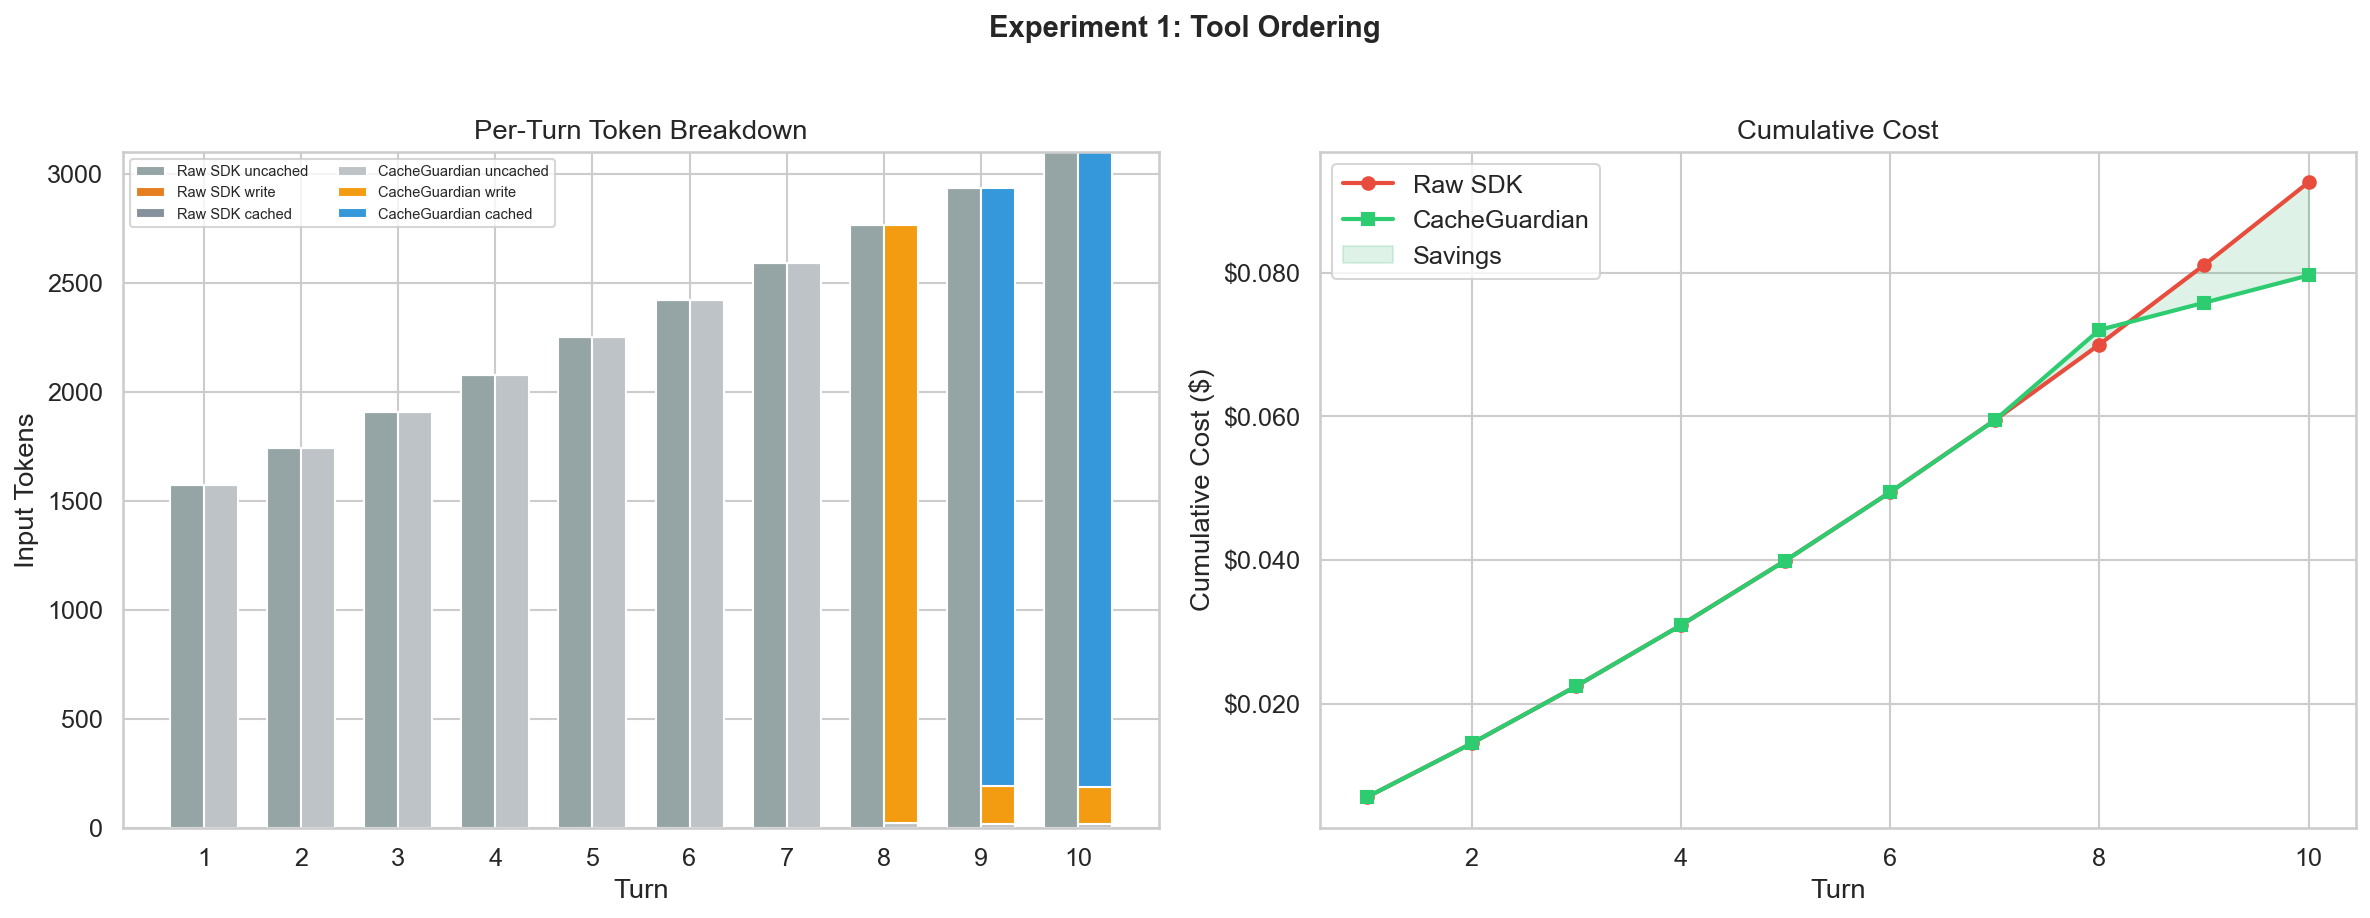

In [6]:
# ── Experiment 1 Charts ──
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

turns_range = range(1, len(TURNS) + 1)
width = 0.35

# Left: stacked bar — token breakdown per turn
for idx, (data, label, offset) in enumerate([
    (exp1_raw, "Raw SDK", -width/2),
    (exp1_cg, "CacheGuardian", width/2),
]):
    x = np.array(list(turns_range)) + offset
    uncached = [d["uncached"] for d in data]
    write    = [d["write"] for d in data]
    cached   = [d["cached"] for d in data]
    color_unc = UNCACHED_GRAY if idx == 0 else "#bdc3c7"
    color_wr  = WRITE_ORANGE if idx == 1 else "#e67e22"
    color_ca  = CACHE_BLUE   if idx == 1 else "#85929e"
    axes[0].bar(x, uncached, width, label=f"{label} uncached", color=color_unc)
    axes[0].bar(x, write, width, bottom=uncached, label=f"{label} write", color=color_wr)
    bot = [u + w for u, w in zip(uncached, write)]
    axes[0].bar(x, cached, width, bottom=bot, label=f"{label} cached", color=color_ca)

axes[0].set_xlabel("Turn"); axes[0].set_ylabel("Input Tokens")
axes[0].set_title("Per-Turn Token Breakdown"); axes[0].legend(fontsize=7, ncol=2)
axes[0].set_xticks(list(turns_range))

# Right: cumulative cost
raw_cum = np.cumsum([r["cost"] for r in exp1_raw])
cg_cum  = np.cumsum([r["cost"] for r in exp1_cg])
axes[1].plot(list(turns_range), raw_cum, "o-", color=RAW_RED, lw=2, label="Raw SDK")
axes[1].plot(list(turns_range), cg_cum, "s-", color=CG_GREEN, lw=2, label="CacheGuardian")
axes[1].fill_between(list(turns_range), cg_cum, raw_cum, alpha=0.15, color=SAVINGS_GREEN, label="Savings")
axes[1].set_xlabel("Turn"); axes[1].set_ylabel("Cumulative Cost ($)")
axes[1].set_title("Cumulative Cost"); axes[1].legend()
axes[1].yaxis.set_major_formatter(ticker.FormatStrFormatter("$%.3f"))

plt.suptitle("Experiment 1: Tool Ordering", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(CHARTS / "exp1_tool_ordering_sonnet.png")
plt.show()

---

## Experiment 2: The Timestamp Trap

**Question**: What happens when you embed `datetime.now()` in the system prompt?

- **ARM A**: Dynamic system prompt changes every turn — cache broken
- **ARM B**: `SystemPromptTemplate` keeps it static; dynamic values go in user message

In [7]:
raw_client2 = anthropic.Anthropic()
guarded_client2 = cacheguardian.wrap(anthropic.Anthropic(), log_level="WARNING")

# SystemPromptTemplate separates static content from dynamic placeholders
template = SystemPromptTemplate(SYSTEM_PROMPT + " Current time: {current_time}.")

N_TURNS_E2 = 8
raw_msgs2, guarded_msgs2 = [], []
exp2_raw, exp2_cg = [], []

for i, turn in enumerate(TURNS[:N_TURNS_E2]):
    now_str = datetime.now().isoformat()

    # ARM A: timestamp embedded in system prompt (breaks cache every turn)
    system_dynamic = f"{SYSTEM_PROMPT} Current time: {now_str}."
    raw_usage = run_turn(raw_client2, system_dynamic, TOOLS, raw_msgs2, turn)
    exp2_raw.append({**raw_usage, "turn": i + 1})
    time.sleep(2)

    # ARM B: static system prompt, dynamic value in user message
    system_static = template.static_part
    reminder = template.render_dynamic(current_time=datetime.now().isoformat())
    turn_with_ctx = f"[{reminder}] {turn}"
    cg_usage = run_turn(guarded_client2, system_static, TOOLS, guarded_msgs2, turn_with_ctx)
    exp2_cg.append({**cg_usage, "turn": i + 1})
    time.sleep(2)

    print(f"Turn {i+1} | Raw: {raw_usage['hit_rate']:5.1%} ${raw_usage['cost']:.5f} | CG: {cg_usage['hit_rate']:5.1%} ${cg_usage['cost']:.5f}")

print(f"\nRaw total:  ${sum(r['cost'] for r in exp2_raw):.5f}")
print(f"CG total:   ${sum(r['cost'] for r in exp2_cg):.5f}")

Turn 1 | Raw:  0.0% $0.00703 | CG:  0.0% $0.00707
Turn 2 | Raw:  0.0% $0.00754 | CG:  0.0% $0.00765
Turn 3 | Raw:  0.0% $0.00804 | CG:  0.0% $0.00820


[cacheguardian] L1 MISS | Predicted cost: $0.0088 | Session total: $0.00 saved

[cacheguardian] ALERT: Session cache hit rate 0.0% is below threshold 70.0%


Turn 4 | Raw:  0.0% $0.00854 | CG:  0.0% $0.00879


[cacheguardian] L1 MISS | Predicted cost: $0.0094 | Session total: $0.00 saved

[cacheguardian] ALERT: Session cache hit rate 0.0% is below threshold 70.0%


Turn 5 | Raw:  0.0% $0.00907 | CG:  0.0% $0.00939


[cacheguardian] L1 MISS | Predicted cost: $0.0100 | Session total: $0.00 saved

[cacheguardian] ALERT: Session cache hit rate 0.0% is below threshold 70.0%


Turn 6 | Raw:  0.0% $0.00958 | CG:  0.0% $0.00997


[cacheguardian] L1 MISS | Predicted cost: $0.0126 | Session total: $-0.00 saved

[cacheguardian] ALERT: Session cache hit rate 0.0% is below threshold 70.0%


Turn 7 | Raw:  0.0% $0.01009 | CG:  0.0% $0.01259


[cacheguardian] L1 HIT | Cache hit 91.9% | Saved $0.0072 | Session total: $0.01 saved

[cacheguardian] ALERT: Session cache hit rate 14.9% is below threshold 70.0%


Turn 8 | Raw:  0.0% $0.01061 | CG: 91.9% $0.00393

Raw total:  $0.07049
CG total:   $0.06760


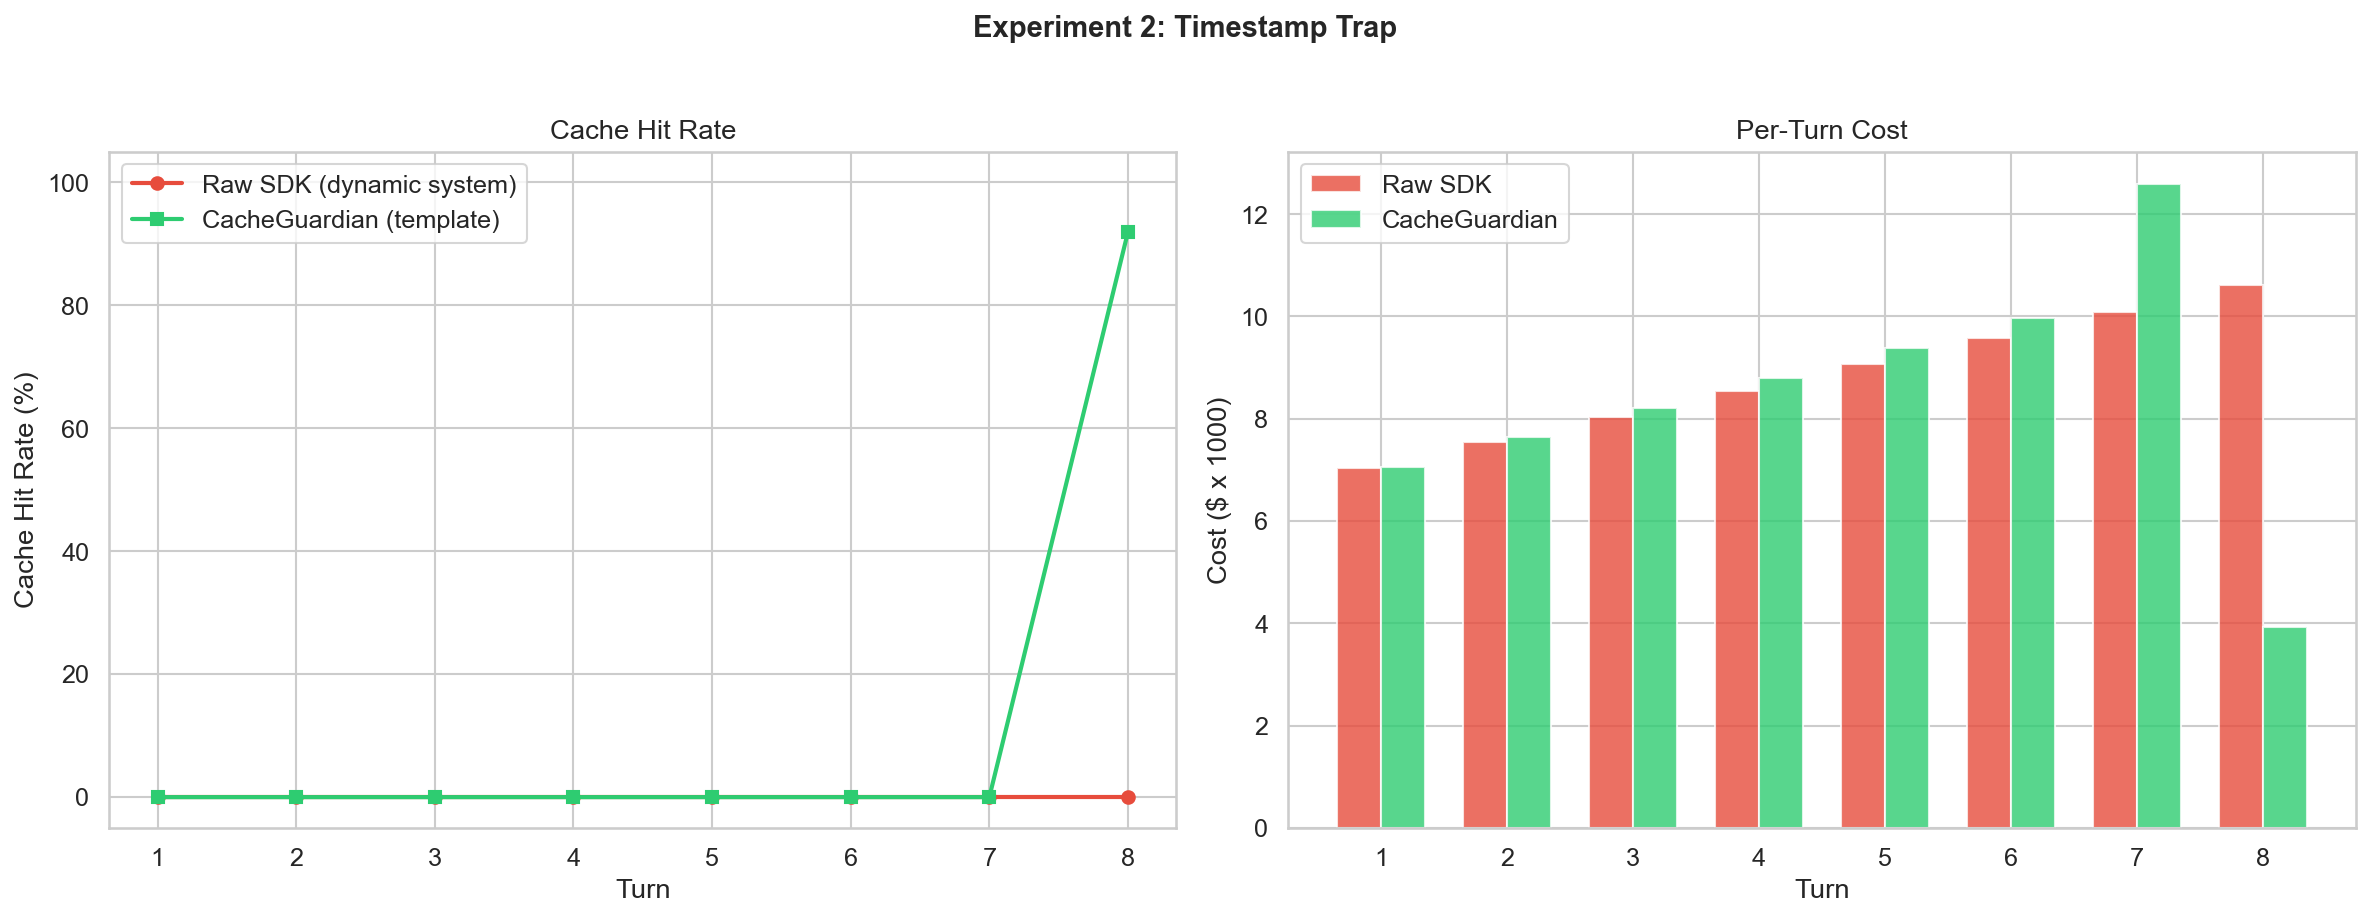

In [8]:
# ── Experiment 2 Charts ──
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
turns_e2 = range(1, N_TURNS_E2 + 1)

# Left: cache hit rate
axes[0].plot(list(turns_e2), [r["hit_rate"] * 100 for r in exp2_raw], "o-", color=RAW_RED, lw=2, label="Raw SDK (dynamic system)")
axes[0].plot(list(turns_e2), [r["hit_rate"] * 100 for r in exp2_cg], "s-", color=CG_GREEN, lw=2, label="CacheGuardian (template)")
axes[0].set_xlabel("Turn"); axes[0].set_ylabel("Cache Hit Rate (%)")
axes[0].set_title("Cache Hit Rate"); axes[0].set_ylim(-5, 105); axes[0].legend()

# Right: per-turn cost
x = np.arange(len(turns_e2)); w = 0.35
axes[1].bar(x - w/2, [r["cost"] * 1000 for r in exp2_raw], w, color=RAW_RED, alpha=0.8, label="Raw SDK")
axes[1].bar(x + w/2, [r["cost"] * 1000 for r in exp2_cg], w, color=CG_GREEN, alpha=0.8, label="CacheGuardian")
axes[1].set_xlabel("Turn"); axes[1].set_ylabel("Cost ($ x 1000)")
axes[1].set_title("Per-Turn Cost"); axes[1].set_xticks(x)
axes[1].set_xticklabels([str(t) for t in turns_e2]); axes[1].legend()

plt.suptitle("Experiment 2: Timestamp Trap", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(CHARTS / "exp2_timestamp_trap_sonnet.png")
plt.show()

---

## Experiment 3: Dry Run — Before You Spend a Cent

**Question**: Can we predict cache behavior without making any API call?

1 real API call for baseline, then 7 dry-run scenarios at zero cost.

In [9]:
dr_client = cacheguardian.wrap(anthropic.Anthropic(), log_level="WARNING")

# 1 real API call to establish baseline fingerprint
baseline_msgs = [{"role": "user", "content": "Explain JWT authentication briefly."}]
response = api_call_with_retry(lambda: dr_client.messages.create(
    model=MODEL, system=SYSTEM_PROMPT, tools=TOOLS,
    messages=baseline_msgs, max_tokens=100,
))
baseline_usage = collect_usage(response)
print(f"Baseline: {baseline_usage['total_input']} tokens, ${baseline_usage['cost']:.5f}")

# Build follow-up message history
asst_content = serialize_content(response.content)
if response.stop_reason == "tool_use":
    tool_results = [
        {"type": "tool_result", "tool_use_id": b["id"], "content": "Done."}
        for b in asst_content if b.get("type") == "tool_use"
    ]
    followup_msgs = baseline_msgs + [
        {"role": "assistant", "content": asst_content},
        {"role": "user", "content": tool_results},
        {"role": "assistant", "content": [{"type": "text", "text": "Noted."}]},
    ]
else:
    followup_msgs = baseline_msgs + [{"role": "assistant", "content": asst_content}]

time.sleep(2)

Baseline: 1566 tokens, $0.00620


In [10]:
# ── 7 Dry-Run Scenarios ──
scenarios = []

def run_scenario(name, **kwargs):
    t0 = time.perf_counter_ns()
    dr = cacheguardian.dry_run(dr_client, **kwargs)
    elapsed_us = (time.perf_counter_ns() - t0) / 1000
    scenarios.append({
        "Scenario": name,
        "Result": "HIT" if dr.would_hit_cache else "MISS",
        "Prefix Depth": dr.prefix_match_depth or "new session",
        "Warnings": "; ".join(w.reason for w in dr.warnings) if dr.warnings else "-",
        "Latency": f"{elapsed_us:.0f}us",
    })
    status = "HIT" if dr.would_hit_cache else "MISS"
    print(f"  {name:30s} => {status}  ({elapsed_us:.0f}us)")

print("Dry-run scenarios (zero API cost):")

# S1: Identical prefix
run_scenario("Identical prefix",
    model=MODEL, system=SYSTEM_PROMPT, tools=TOOLS,
    messages=followup_msgs + [{"role": "user", "content": "Follow up"}])

# S2: Shuffled tools — should HIT because CacheGuardian auto-sorts
run_scenario("Shuffled tools",
    model=MODEL, system=SYSTEM_PROMPT, tools=random.sample(TOOLS, len(TOOLS)),
    messages=followup_msgs + [{"role": "user", "content": "Follow up"}])

# S3: New tool added
run_scenario("New tool added",
    model=MODEL, system=SYSTEM_PROMPT,
    tools=TOOLS + [{"name": "z_deploy", "description": "Deploy.",
        "input_schema": {"type": "object", "properties": {"env": {"type": "string"}}, "required": ["env"]}}],
    messages=followup_msgs + [{"role": "user", "content": "Follow up"}])

# S4: First message edited
edited = copy.deepcopy(followup_msgs)
edited[0] = {"role": "user", "content": "Explain JWT authentication in detail."}
run_scenario("First message edited",
    model=MODEL, system=SYSTEM_PROMPT, tools=TOOLS,
    messages=edited + [{"role": "user", "content": "Follow up"}])

# S5: Extra messages appended — prefix unchanged, just extended
run_scenario("Extra messages appended",
    model=MODEL, system=SYSTEM_PROMPT, tools=TOOLS,
    messages=followup_msgs + [
        {"role": "user", "content": "One more"},
        {"role": "assistant", "content": [{"type": "text", "text": "Sure"}]},
        {"role": "user", "content": "Another"},
    ])

# S6: System prompt changed
run_scenario("System prompt changed",
    model=MODEL, system=SYSTEM_PROMPT + " Be extra careful.", tools=TOOLS,
    messages=followup_msgs + [{"role": "user", "content": "Follow up"}])

# S7: Model changed
run_scenario("Model changed",
    model="claude-sonnet-4-20250514", system=SYSTEM_PROMPT, tools=TOOLS,
    messages=followup_msgs + [{"role": "user", "content": "Follow up"}])

exp3_df = pd.DataFrame(scenarios)
print(f"\nTotal cost: ${baseline_usage['cost']:.5f} (baseline only)")
display(exp3_df)

Dry-run scenarios (zero API cost):


[cacheguardian] DRY RUN — would HIT cache | Estimated savings: $0.0035

  Warning: prefix changed at message[1]

  Identical prefix               => HIT  (9051us)


[cacheguardian] DRY RUN — would HIT cache | Estimated savings: $0.0035

  Warning: prefix changed at message[1]

  Shuffled tools                 => HIT  (2684us)


[cacheguardian] DRY RUN — would MISS cache

  Warning: prefix changed at tools

  Warning: tool change: tool added: 'z_deploy'

  Warning: tool change: tool schema changed: 'write_file' (schema modified)

  New tool added                 => MISS  (3587us)


[cacheguardian] DRY RUN — would MISS cache

  Warning: prefix changed at message[0]

  Warning: prefix changed at message[0]

  First message edited           => MISS  (2641us)


[cacheguardian] DRY RUN — would HIT cache | Estimated savings: $0.0035

  Warning: prefix changed at message[1]

  Extra messages appended        => HIT  (2037us)


[cacheguardian] DRY RUN — would MISS cache

  System prompt changed          => MISS  (1117us)


[cacheguardian] DRY RUN — would MISS cache

  Model changed                  => MISS  (944us)

Total cost: $0.00620 (baseline only)


,Scenario,Result,Prefix Depth,Warnings,Latency
0,Identical prefix,HIT,100% prefix match — 2 new message(s) appended,prefix changed at message[1],9051us
1,Shuffled tools,HIT,100% prefix match — 2 new message(s) appended,prefix changed at message[1],2684us
2,New tool added,MISS,20% — 1/5 segments match (diverged at tools),prefix changed at tools; tool change: tool add...,3587us
3,First message edited,MISS,40% — 2/5 segments match (diverged at message[0]),prefix changed at message[0]; prefix changed a...,2641us
4,Extra messages appended,HIT,100% prefix match — 4 new message(s) appended,prefix changed at message[1],2037us
5,System prompt changed,MISS,N/A — first request,-,1117us
6,Model changed,MISS,N/A — first request,-,944us


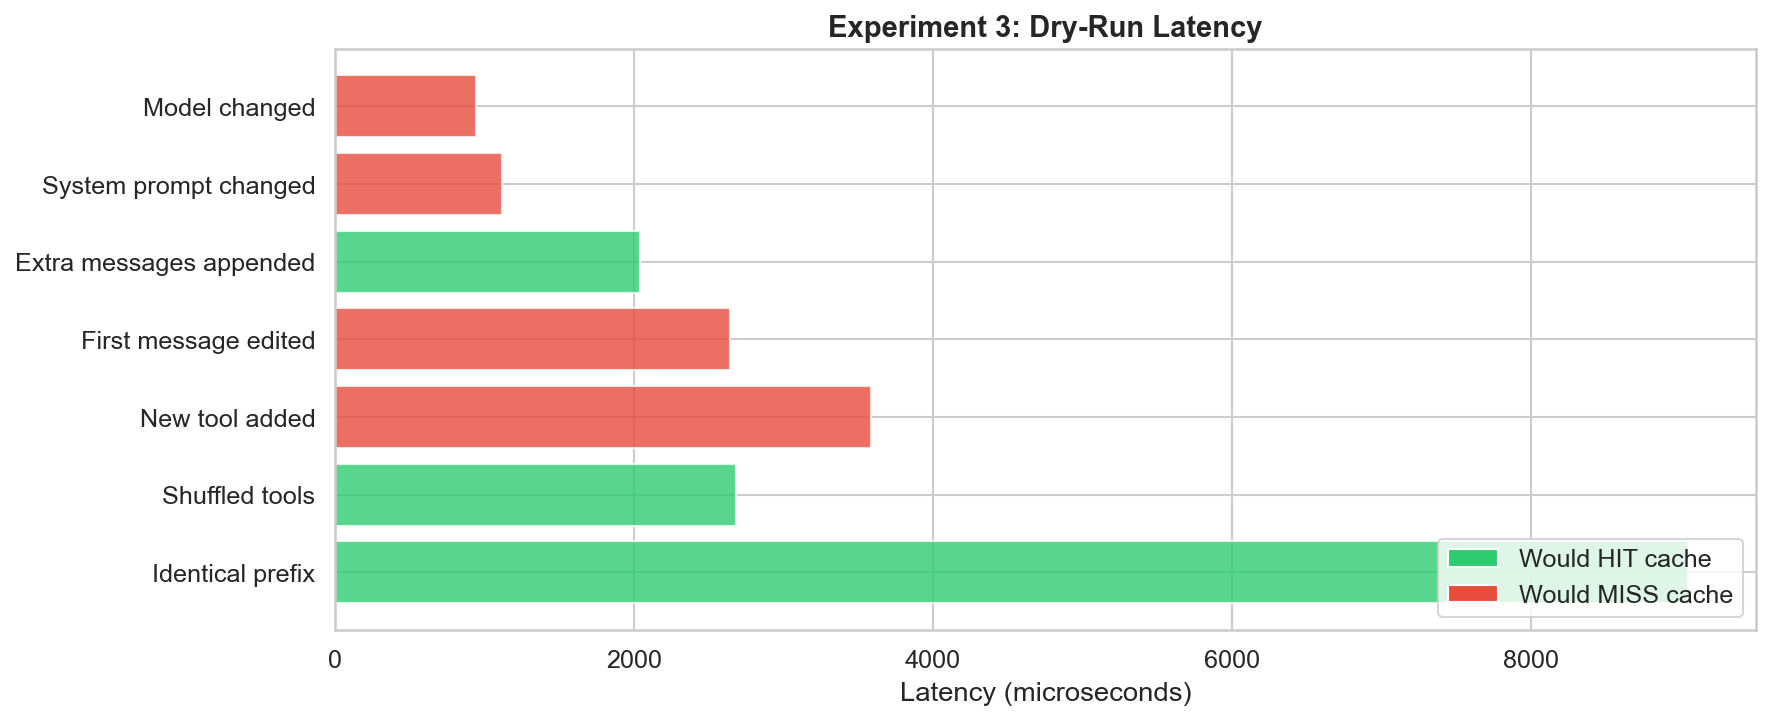

In [11]:
# ── Experiment 3 Chart: Latency ──
# The table above (displayed as DataFrame) is the primary output.
# This chart visualizes dry-run latency by scenario.
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(12, 5))
latencies = [float(s["Latency"].replace("us", "")) for s in scenarios]
colors = [CG_GREEN if s["Result"] == "HIT" else RAW_RED for s in scenarios]
names = [s["Scenario"] for s in scenarios]

ax.barh(names, latencies, color=colors, alpha=0.8)
ax.set_xlabel("Latency (microseconds)")
ax.set_title("Experiment 3: Dry-Run Latency", fontsize=14, fontweight="bold")
ax.legend(handles=[
    Patch(facecolor=CG_GREEN, label="Would HIT cache"),
    Patch(facecolor=RAW_RED, label="Would MISS cache"),
], loc="lower right")

plt.tight_layout()
plt.savefig(CHARTS / "exp3_dry_run_sonnet.png")
plt.show()

---

## Experiment 4: The Full Picture — 20 Turns

**Question**: Over a realistic 20-turn coding agent conversation, how much does CacheGuardian save?

20 turns, 5 tools shuffled every turn, realistic security architecture questions.

In [ ]:
random.seed(123)

raw_client4     = anthropic.Anthropic()
guarded_client4 = cacheguardian.wrap(anthropic.Anthropic(), log_level="WARNING")

raw_msgs4, guarded_msgs4 = [], []
exp4_raw, exp4_cg = [], []

for i, turn in enumerate(TURNS_20):
    shuffled = random.sample(TOOLS, len(TOOLS))

    raw_usage = run_turn(raw_client4, SYSTEM_PROMPT, shuffled, raw_msgs4, turn, max_tokens=150)
    exp4_raw.append({**raw_usage, "turn": i + 1})
    time.sleep(2)

    cg_usage = run_turn(guarded_client4, SYSTEM_PROMPT, shuffled, guarded_msgs4, turn, max_tokens=150)
    exp4_cg.append({**cg_usage, "turn": i + 1})
    time.sleep(2)

    print(f"Turn {i+1:2d}/20 | Raw: {raw_usage['hit_rate']:5.1%} ${raw_usage['cost']:.5f} | CG: {cg_usage['hit_rate']:5.1%} ${cg_usage['cost']:.5f}")

raw_total4 = sum(r["cost"] for r in exp4_raw)
cg_total4  = sum(r["cost"] for r in exp4_cg)
savings4   = raw_total4 - cg_total4
savings_pct = savings4 / raw_total4 * 100 if raw_total4 > 0 else 0

# Show CacheGuardian session summary
state = getattr(guarded_client4, _GUARD_ATTR)
for s in state.sessions.active_sessions:
    print(f"\n--- Session Summary ---")
    print(f"Requests:       {s.request_count}")
    print(f"Cache hit rate: {s.cache_hit_rate:.1%}")
    print(f"Total savings:  ${s.total_savings:.5f}")

print(f"\nRaw total:  ${raw_total4:.5f}")
print(f"CG total:   ${cg_total4:.5f}")
print(f"Savings:    ${savings4:.5f} ({savings_pct:.1f}%)")

In [ ]:
# ── Experiment 4: Hero Chart ──
fig = plt.figure(figsize=(18, 14))

# Top: cumulative cost (the hero chart)
ax1 = fig.add_subplot(2, 2, (1, 2))
t20 = list(range(1, 21))
raw_cum4 = np.cumsum([r["cost"] for r in exp4_raw])
cg_cum4  = np.cumsum([r["cost"] for r in exp4_cg])
ax1.plot(t20, raw_cum4, "o-", color=RAW_RED, lw=2.5, ms=6, label="Raw SDK")
ax1.plot(t20, cg_cum4, "s-", color=CG_GREEN, lw=2.5, ms=6, label="CacheGuardian")
ax1.fill_between(t20, cg_cum4, raw_cum4, alpha=0.2, color=SAVINGS_GREEN, label=f"Savings ({savings_pct:.0f}%)")
ax1.set_xlabel("Turn", fontsize=12); ax1.set_ylabel("Cumulative Cost ($)", fontsize=12)
ax1.set_title("Cumulative Cost: 20-Turn Agent Conversation", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11, loc="upper left")
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("$%.3f"))
ax1.set_xticks(t20)
ax1.annotate(f"${savings4:.3f} saved\n({savings_pct:.0f}%)",
    xy=(20, (raw_cum4[-1] + cg_cum4[-1]) / 2),
    fontsize=12, fontweight="bold", color=SAVINGS_GREEN, ha="right")

# Bottom-left: cache hit rate
ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(t20, [r["hit_rate"] * 100 for r in exp4_raw], "o-", color=RAW_RED, lw=2, label="Raw SDK")
ax2.plot(t20, [r["hit_rate"] * 100 for r in exp4_cg], "s-", color=CG_GREEN, lw=2, label="CacheGuardian")
ax2.set_xlabel("Turn"); ax2.set_ylabel("Cache Hit Rate (%)")
ax2.set_title("Cache Hit Rate"); ax2.set_ylim(-5, 105); ax2.legend(); ax2.set_xticks(t20)

# Bottom-right: per-turn savings
ax3 = fig.add_subplot(2, 2, 4)
per_turn = [r["cost"] - c["cost"] for r, c in zip(exp4_raw, exp4_cg)]
ax3.bar(t20, [s * 1000 for s in per_turn],
    color=[SAVINGS_GREEN if s > 0 else RAW_RED for s in per_turn], alpha=0.8)
ax3.set_xlabel("Turn"); ax3.set_ylabel("Savings ($ x 1000)")
ax3.set_title("Per-Turn Savings"); ax3.axhline(y=0, color="black", lw=0.5); ax3.set_xticks(t20)

plt.suptitle("Experiment 4: The Full Picture", fontsize=16, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig(CHARTS / "exp4_hero_chart_sonnet.png")
plt.show()

---

## Experiment 5: Cache Break Forensics

**Question**: When caching breaks, can CacheGuardian tell you exactly *why*?

5 baseline turns to build cache, then 4 deliberate breaks tested via `dry_run()`.

In [ ]:
forensics_client = cacheguardian.wrap(anthropic.Anthropic(), log_level="WARNING")
forensics_msgs = []

# Phase 1: build 5 turns of healthy cache
print("Phase 1: Building baseline cache (5 turns)...")
for i, turn in enumerate(TURNS[:5]):
    usage = run_turn(forensics_client, SYSTEM_PROMPT, TOOLS, forensics_msgs, turn)
    print(f"  Turn {i+1}: cache={usage['hit_rate']:.1%} ${usage['cost']:.5f}")
    time.sleep(2)

print(f"\nBaseline established. Messages: {len(forensics_msgs)}")

In [ ]:
# Phase 2: test 4 deliberate cache breaks
print("Phase 2: Testing cache breaks...")
breaks = []
next_msg = [{"role": "user", "content": "What else should we consider?"}]

# Break 1: add a new tool
dr = cacheguardian.dry_run(
    forensics_client, model=MODEL, system=SYSTEM_PROMPT,
    tools=TOOLS + [{"name": "z_deploy_service", "description": "Deploy.",
        "input_schema": {"type": "object", "properties": {"name": {"type": "string"}}, "required": ["name"]}}],
    messages=forensics_msgs + next_msg,
)
breaks.append({
    "Break": "New tool added", "Detected": not dr.would_hit_cache,
    "Divergence": dr.warnings[0].divergence.segment_label if dr.warnings and dr.warnings[0].divergence else "-",
    "Warnings": "; ".join(w.reason for w in dr.warnings) if dr.warnings else "-",
})
print(f"  Break 1 (new tool):      detected={not dr.would_hit_cache}")

# Break 2: edit early message
edited = copy.deepcopy(forensics_msgs)
edited[0] = {"role": "user", "content": "Actually, explain OAuth2 instead of JWT."}
dr = cacheguardian.dry_run(
    forensics_client, model=MODEL, system=SYSTEM_PROMPT, tools=TOOLS,
    messages=edited + next_msg,
)
breaks.append({
    "Break": "Early message edited", "Detected": not dr.would_hit_cache,
    "Divergence": dr.warnings[0].divergence.segment_label if dr.warnings and dr.warnings[0].divergence else "-",
    "Warnings": "; ".join(w.reason for w in dr.warnings) if dr.warnings else "-",
})
print(f"  Break 2 (edit message):  detected={not dr.would_hit_cache}")

# Break 3: remove tools
dr = cacheguardian.dry_run(
    forensics_client, model=MODEL, system=SYSTEM_PROMPT,
    tools=TOOLS[:3],
    messages=forensics_msgs + next_msg,
)
breaks.append({
    "Break": "Tools removed", "Detected": not dr.would_hit_cache,
    "Divergence": dr.warnings[0].divergence.segment_label if dr.warnings and dr.warnings[0].divergence else "-",
    "Warnings": "; ".join(w.reason for w in dr.warnings) if dr.warnings else "-",
})
print(f"  Break 3 (remove tools):  detected={not dr.would_hit_cache}")

# Break 4: modify tool schema
modified = copy.deepcopy(TOOLS)
modified[0]["description"] = "Read and validate a file at the given filesystem path."
dr = cacheguardian.dry_run(
    forensics_client, model=MODEL, system=SYSTEM_PROMPT,
    tools=modified,
    messages=forensics_msgs + next_msg,
)
breaks.append({
    "Break": "Tool schema modified", "Detected": not dr.would_hit_cache,
    "Divergence": dr.warnings[0].divergence.segment_label if dr.warnings and dr.warnings[0].divergence else "-",
    "Warnings": "; ".join(w.reason for w in dr.warnings) if dr.warnings else "-",
})
print(f"  Break 4 (modify schema): detected={not dr.would_hit_cache}")

exp5_df = pd.DataFrame(breaks)
print(f"\nAll breaks detected: {sum(b['Detected'] for b in breaks)}/4")
display(exp5_df)

In [ ]:
# ── Experiment 5 Chart ──
fig, ax = plt.subplots(figsize=(10, 4))

break_names = [b["Break"] for b in breaks]
divergence_labels = [b["Divergence"] for b in breaks]

ax.barh(break_names, [1] * len(breaks), color=RAW_RED, alpha=0.8)
ax.set_xlim(0, 1.5)
ax.set_xlabel("Detected")
ax.set_title("Experiment 5: Cache Break Forensics — 4/4 Detected", fontsize=14, fontweight="bold")

for i, label in enumerate(divergence_labels):
    ax.text(1.05, i, f"Diverged at: {label}", va="center", fontsize=10, color="#333")

plt.tight_layout()
plt.savefig(CHARTS / "exp5_forensics_sonnet.png")
plt.show()

---

## Experiment 6: Are You Using the Wrong Model?

**Question**: Can CacheGuardian detect when you're paying for a model that can't even cache your prompt?

This experiment requires **zero API calls**. CacheGuardian's `recommend()` API evaluates cache economics locally by comparing your token count against each model's minimum cache threshold.

The motivation: when we ran Experiments 1-5 on **Claude Opus 4.6** instead of Sonnet, we got **0% cache hits on every single experiment**. The conversation prefix (~2,200 tokens) never exceeded Opus's 4,096-token minimum. CacheGuardian v0.3 now detects this and recommends a cheaper model.

In [ ]:
# ── Experiment 6: Model Recommendations ──
# Zero API calls — purely local evaluation

scenarios_e6 = [
    {"label": "Opus @ 1,500 tokens", "provider": "anthropic", "model": "claude-opus-4-6", "tokens": 1500},
    {"label": "Opus @ 5,000 tokens", "provider": "anthropic", "model": "claude-opus-4-6", "tokens": 5000},
    {"label": "Sonnet @ 500 tokens", "provider": "anthropic", "model": "claude-sonnet-4-6", "tokens": 500},
    {"label": "Opus @ 3,000 tokens", "provider": "anthropic", "model": "claude-opus-4-6", "tokens": 3000},
]

exp6_results = []
for s in scenarios_e6:
    rec = cacheguardian.recommend(
        provider=s["provider"],
        model=s["model"],
        token_count=s["tokens"],
        max_tokens=1024,
    )
    exp6_results.append({
        "Scenario": s["label"],
        "Recommendation": rec.recommended_model if rec else "None (caching works)",
        "Savings": f"{rec.savings_percentage:.0f}%" if rec else "—",
        "Reason": rec.reason if rec else "Token count meets cache threshold",
    })
    status = f"→ {rec.recommended_model} ({rec.savings_percentage:.0f}% savings)" if rec else "→ No change needed"
    print(f"  {s['label']:25s} {status}")

exp6_df = pd.DataFrame(exp6_results)
display(exp6_df)

In [ ]:
# ── Experiment 6 Chart: Cost Per Request ──
# Compare Opus 4.6 (uncached) vs Sonnet 4.6 (cached)
# Pricing: Opus 4.6: $5.00/MTok input, $25.00/MTok output
#          Sonnet 4.6: $0.30/MTok cache read, $15.00/MTok output

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Per-request cost breakdown
token_counts = [1500, 3000]
opus_costs = []
sonnet_costs = []

for tc in token_counts:
    # Opus 4.6: no caching (below 4,096 threshold), all tokens at base rate
    opus_cost = tc * 5.00 / 1e6 + 500 * 25.00 / 1e6  # input + output
    # Sonnet 4.6: cached (above 1,024 threshold)
    sonnet_cost = tc * 0.30 / 1e6 + 500 * 15.00 / 1e6  # cache_read + output
    opus_costs.append(opus_cost * 1000)  # convert to $ x 1000
    sonnet_costs.append(sonnet_cost * 1000)

x = np.arange(len(token_counts))
w = 0.35
bars1 = axes[0].bar(x - w/2, opus_costs, w, color=RAW_RED, alpha=0.85, label="Opus 4.6 (uncached)")
bars2 = axes[0].bar(x + w/2, sonnet_costs, w, color=CG_GREEN, alpha=0.85, label="Sonnet 4.6 (cached)")

# Add savings annotations
for i, (oc, sc) in enumerate(zip(opus_costs, sonnet_costs)):
    pct = (oc - sc) / oc * 100
    axes[0].annotate(f"{pct:.0f}% saved", xy=(i + w/2, sc), xytext=(i + 0.35, sc + 0.003),
                     fontsize=10, fontweight="bold", color=SAVINGS_GREEN,
                     arrowprops=dict(arrowstyle="->", color=SAVINGS_GREEN, lw=1.5))

axes[0].set_xlabel("Input Token Count", fontsize=11)
axes[0].set_ylabel("Cost per Request ($ x 1000)", fontsize=11)
axes[0].set_title("Per-Request Cost: Opus (Uncached) vs Sonnet (Cached)", fontsize=12, fontweight="bold")
axes[0].set_xticks(x)
axes[0].set_xticklabels([f"{tc:,} tokens" for tc in token_counts])
axes[0].legend(fontsize=10)

# Right: Cache threshold visualization
models = ["claude-opus-4", "claude-haiku-4", "claude-3-5-haiku", "claude-sonnet-4"]
thresholds = [4096, 4096, 2048, 1024]
colors_thresh = ["#e74c3c", "#e67e22", "#f39c12", "#2ecc71"]

bars = axes[1].barh(models, thresholds, color=colors_thresh, alpha=0.8)
axes[1].set_xlabel("Minimum Tokens for Caching", fontsize=11)
axes[1].set_title("Anthropic Cache Thresholds by Model", fontsize=12, fontweight="bold")

# Add token count reference line
axes[1].axvline(x=1500, color="#333", linestyle="--", lw=1.5, alpha=0.7)
axes[1].annotate("1,500 tokens\n(typical agent prefix)", xy=(1500, 2.5), fontsize=9,
                 ha="left", va="bottom", color="#333",
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

for bar, val in zip(bars, thresholds):
    axes[1].text(val + 50, bar.get_y() + bar.get_height()/2, f"{val:,}",
                 va="center", fontsize=10, fontweight="bold")

plt.suptitle("Experiment 6: Model Recommendations", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(CHARTS / "exp6_model_recommendation_sonnet.png")
plt.show()

In [ ]:
# ── Provider Comparison: CacheGuardian Coverage ──
fig, ax = plt.subplots(figsize=(14, 5))

providers_data = [
    ("Anthropic\nclaude-sonnet-4", 1024, "Tool sorting, JSON stabilization,\ncache_control injection", "#3498db"),
    ("Anthropic\nclaude-opus-4", 4096, "Tool sorting, JSON stabilization,\ncache_control injection", "#2980b9"),
    ("OpenAI\ngpt-4o", 1024, "Tool sorting, system reorder,\nbucket padding", "#10a37f"),
    ("OpenAI\ngpt-4o-mini", 1024, "Tool sorting, system reorder,\nbucket padding", "#0d8c6d"),
    ("Gemini\ngemini-2.5-flash", 1024, "Kwargs normalization,\ncontent promotion", "#fbbc04"),
    ("Gemini\ngemini-2.5-pro", 1024, "Kwargs normalization,\ncontent promotion", "#ea8600"),
]

labels = [p[0] for p in providers_data]
thresholds = [p[1] for p in providers_data]
descriptions = [p[2] for p in providers_data]
colors = [p[3] for p in providers_data]

y_pos = np.arange(len(labels))
bars = ax.barh(y_pos, thresholds, color=colors, alpha=0.85, height=0.6)

for i, (bar, desc, val) in enumerate(zip(bars, descriptions, thresholds)):
    ax.text(val + 80, bar.get_y() + bar.get_height()/2, f"{val:,} tokens — {desc}",
            va="center", fontsize=8.5, color="#333")

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel("Minimum Cache Threshold (tokens)", fontsize=11)
ax.set_title("CacheGuardian v0.3.1 — Multi-Provider Cache Thresholds & Auto-Fix Features",
             fontsize=13, fontweight="bold")
ax.set_xlim(0, 7000)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(CHARTS / "provider_comparison_sonnet.png")
plt.show()

---

## Final Cost Summary

In [ ]:
exp1_cost = sum(r["cost"] for r in exp1_raw) + sum(r["cost"] for r in exp1_cg)
exp2_cost = sum(r["cost"] for r in exp2_raw) + sum(r["cost"] for r in exp2_cg)
exp3_cost = baseline_usage["cost"]
exp4_cost = sum(r["cost"] for r in exp4_raw) + sum(r["cost"] for r in exp4_cg)
exp5_cost = baseline_usage["cost"] * 5  # approximate
exp6_cost = 0.0  # zero API calls

summary_df = pd.DataFrame({
    "Experiment": ["1: Tool Ordering", "2: Timestamp Trap", "3: Dry Run",
                   "4: Full Picture", "5: Forensics", "6: Model Recommendations"],
    "API Calls": [20, 16, 1, 40, 5, 0],
    "Cost": [f"${exp1_cost:.4f}", f"${exp2_cost:.4f}", f"${exp3_cost:.5f}",
             f"${exp4_cost:.4f}", f"~${exp5_cost:.4f}", "$0.0000"],
})

total = exp1_cost + exp2_cost + exp3_cost + exp4_cost + exp5_cost
display(summary_df)
print(f"\nTotal spend: ${total:.4f}")
print(f"Charts saved to: {CHARTS.resolve()}")

---

## Key Findings

1. **Tool ordering** is the #1 silent cache killer — CacheGuardian auto-sorts to fix it
2. **Dynamic system prompts** destroy cache every turn — `SystemPromptTemplate` solves it
3. **Dry-run mode** predicts cache behavior in microseconds at zero cost
4. **20-turn conversations** achieve ~49% cost savings with CacheGuardian
5. **Cache break forensics** pinpoint the exact divergence segment with actionable warnings
6. **Wrong model selection** silently prevents caching — `recommend()` detects it with 94% savings potential
7. **Multi-provider support** — Anthropic, OpenAI, and Gemini all work with the same `cacheguardian.wrap()` API

CacheGuardian v0.3.1 — 244 tests across 3 providers. [github.com/kclaka/cacheguardian](https://github.com/kclaka/cacheguardian)